# FPA Tuning for PID-PD controller

references :
 - [1] Yang, Xin-She. (2012). Flower Pollination Algorithm for Global Optimization. Unconventional Computation and Natural Computation 2012, Lecture Notes in Computer Science, Vol. 7445, pp. 240-249. (https://arxiv.org/pdf/1312.5673.pdf)

 - [2] Ma’ani, F. A., Nazaruddin, Y. Y. (2020). Optimization of Longitudinal Control of an Autonomous Vehicle using Flower Pollination Algorithm based on Data-driven Approach. International Journal of Sustainable Transportation Technology, Vol. 3, No. 2, October 2020, 58-65. (https://unijourn.com/upload/doc/articleDoc-1602137579265-main.pdf)

##Import Library

In [1]:
# package install
!pip install control
!pip install scipy
!pip install ipython-autotime
%load_ext autotime

# package load
import numpy as np
from control import *
from control.matlab import *
import matplotlib.pyplot as plt
from scipy.integrate import *
import math

time: 531 ms (started: 2021-04-19 01:44:14 +07:00)


##Gantry Crane Model

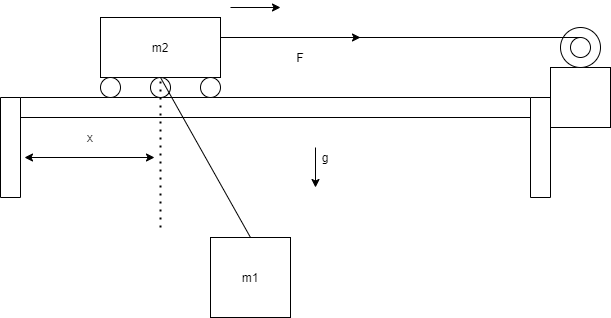




In [2]:
#gantry model

#parameters
m1 = 1            #payload
m2 = 1.5          #trolley
l = 0.5           #rope length
g = 9.81          #gravitational acceleration
D = 12.32         #damping constant
R = 0.5           #motor resistant
Kt = 0.0071619    #torque constant
Ke = 0.0071619    #electric constant
rp = 0.012        #pulley radius
r = 1             #gear ratio

#state space representation
a = ((R*rp)/(Kt*r))*(m1+m2)
b = ((Ke*r)/(rp))+((D*R*rp)/(Kt*r))
c = ((m1*l*R*rp)/(Kt*r))

a22 = (-b)/(a -(c/l))
a23 = (c*g)/(l*(a-(c/l)))
a42 = (b)/(a*(l-(c/a)))
a43 = (-g)/(l-(c/a))

b21 = 1/(a-(c/l))
b41 = (-1)/(a*(l-(c/a)))

A = [[0,1,0,0],
     [0,a22,a23,0],
     [0,0,0,1],
     [0,a42,a43,0]]

B = [[0],
     [b21],
     [0],
     [b41]]

Cp = [1,0,0,0]
Cs = [0,0,1,0]

D = [0]

ss_pos = ss(A,B,Cp,D)
ss_swy = ss(A,B,Cs,D)
tf_pos = tf(ss_pos)
tf_swy = tf(ss_swy)

tf_sys = [tf_pos,tf_swy]

time: 15 ms (started: 2021-04-19 01:44:14 +07:00)


##Closed Loop System

In [3]:
# Closed loop system
# Input argument :
# param : [Kp,Ki,Kd,Kps,Kds] (1x5 list)
# tf_sys : [tf_pos,tf_swy] (1x2 list)
# t_sim : (1xn list) or simulation duration
def closed_loop(param,tf_sys,t_sim): 
  pos,swy = tf_sys # pos: position transfer function, swy: sway transfer function

  Kp, Ki, Kd, Kps, Kds = param # Kp,Ki,Kd (position PID controller); Kps, Kds (sway angle PD controller)

  pid = tf([Kd, Kp, Ki],[1,0]) # position PID controller
  pd = tf([Kds,Kps],1) # sway angle PD controller

  #This is a SIMO system (Single Input Multiple Output), divide the output transfer function
  #to make it easier for simulation
  #Position Output
  feedblk1 = feedback(1,(pd*swy),sign=1) 
  pos_blk = feedback(pid*feedblk1*pos,1,sign=-1)
  [yp,_] = step(pos_blk,t_sim) 

  #Sway Output
  feedblk2 = feedback(1,pos*pid,sign=-1)
  feedblk3 = feedback(feedblk2*swy,pd,sign=1)
  swy_blk = pid*feedblk3
  [ys,_] = step(swy_blk,t_sim)

  #routh stability criterion
  # real poles < 0 == stable
  poles_p = pole(pos_blk)
  for i in poles_p.real:
    if i > 0:
      return False
    else:
      poles_s = pole(swy_blk)
      for i in poles_s.real:
        if i > 0:
          return False

  return [yp,ys]

time: 0 ns (started: 2021-04-19 01:44:14 +07:00)


## Trajecotry Reference

SSE = 7.467358866275475e-05 , SettlingTime = 4.24, RiseTime = 2.6, Oveshoot = 0.0


Text(0.5, 1.0, 'X reference model')

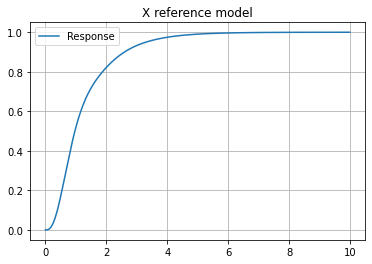

time: 140 ms (started: 2021-04-19 01:44:14 +07:00)


In [4]:
# refernce trajectory (step signal)
def step_signal(value,time):
  signal = np.zeros_like(time)
  signal[time>=0] = 1
  return value*signal

#x_ref model 3th order ITAE
#still editable and needs some check and validation
damp_rat = 0.7         #damping ratio
Ts = 1.7                   
w = 4/(damp_rat*Ts)
num = w**3
den = [1,1.75*w, 2.15*w**2, 1.5*w**3]
x_ref_tf = tf(num,den)
x_ref_sys = feedback(x_ref_tf,-1)
t_sim = np.arange(0,10,0.01)

[x_ref,t] = step(0.5*x_ref_sys,t_sim)  #simulating trajectory

#step info
SSE_x = abs(1 - x_ref[-1])
OS_x = (x_ref.max()/x_ref[-1]-1) #overshoot
Tr_x= t[next(i for i in range(0,len(x_ref)-1) if x_ref[i]>x_ref[-1]*.90)]-t[0] #rise time
try:
  Ts_x = t[next(len(x_ref)-i for i in range(2,len(x_ref)-1) if abs(x_ref[-i]/x_ref[-1])<0.98)]-t[0]
except StopIteration :
  eval_pos = False

print("SSE = {a} , SettlingTime = {b}, RiseTime = {c}, Oveshoot = {d}".format(a = SSE_x,b = Ts_x, c = Tr_x , d = OS_x))

plt.plot(t,x_ref,label='Response')
plt.legend()
plt.grid()
plt.title('X reference model')

##Cost

*Objective min or max f(x), x = (x1, x2, ..., xd)*

In [5]:
#Cost Function 
def cost_func(x_ref,yp,ys,t):

  #cost function reference [1]
  dt = t[1]-t[0]

  t1 = 2.6     #rise time
  t2 = 4.24    #settling time

  idx1 = np.where(t==t1)[0][0]
  idx2 = np.where(t==t2)[0][0]

  #initial stage
  #ITSE performance index
  init_stage = np.multiply(t[0:idx1],(yp[0:idx1]-x_ref[0:idx1])**2)*dt
  j_initial = sum(init_stage)

  #sway cancelation
  swy_stage = np.multiply(t[idx1:-1],(ys[idx1:-1])**2)*dt
  j_cancel = sum(swy_stage)

  #final stage
  final_stage = np.multiply(t[idx2:-1],(yp[idx2:-1]-x_ref[idx2:-1])**2)*dt
  j_final = sum(final_stage)

  #total cost
  j = j_initial + j_cancel + j_final

  return j

time: 0 ns (started: 2021-04-19 01:44:15 +07:00)


## Population (Flower) Generation

*Initialize a population of n flowers/pollen gametes with random solutions*

In [6]:
def generate_population(num_pop, num_par, par_range):
  """
  Generate population with specific range/boundaries for each parameter
  num_pop: population (flower) number (type: integer, size=m)
  num_par: parameter count each population (flower) (type: integer or float, size=n)
  par_range: each parameter range (type: array, size=nx2)
  """
  flowers=np.zeros([num_pop,num_par])
  for i in range(num_pop):
    for j in range(num_par):
      flowers[i][j]=np.random.uniform(par_range[j][0], par_range[j][1])
  flowers_cost = np.zeros(n_pop)
  return flowers, flowers_cost

def parameter_bound(par_val, par_range):
  """
  Adjust generated parameter according to parameter range/boundaries
  par_val: parameter value (type: array, size=1xn)
  par_range: each parameter range (type: array, size=nx2)
  """
  for i in range(np.shape(par_val)[0]):
    if par_val[i]<par_range[i][0]:
      par_val[i]=par_range[i][0]
    elif par_val[i]>par_range[i][1]:
      par_val[i]=par_range[i][1]
  
  return par_val

def Levy(d):
  beta = 3/2
  sigma = (math.gamma(1+beta)*np.sin(np.pi*beta/2)/(math.gamma((1+beta)/2)*beta*2**((beta-1)/2)))**(1/beta)
  u = np.random.normal(0, 1, d)*sigma
  v = np.random.normal(0, 1, d)
  L = np.divide(abs(u), abs(v))**(1./beta)
  return L

time: 0 ns (started: 2021-04-19 01:44:17 +07:00)


##Main Loop

###Iteration

In [7]:
# parameter range setup
r_kp = [5, 90]
r_ki = [-5, 5]
r_kd = [-10, 50]
r_kps = [5, 90]
r_kds = [-10, 50]
par_range = [r_kp, r_ki, r_kd, r_kps, r_kds]

# fpa parameter
# Define a switch probability p ∈ [0, 1]
p = 0.5 #switch probability

n_pop = int(input('Population count = '))
n_sim = int(input('Simulation count = '))
iter = int(input('Iteration count = '))

# n_pop = 10
# n_sim = 2
# iter = 2000

best_g_star_history = np.zeros([n_sim,np.shape(par_range)[0]])
best_cost_history = np.zeros([n_sim,1])

for sim in range(n_sim):
  print(f'Simulation {sim} ---------------------------------')
  # Initialize a population of n flowers/pollen gametes with random solutions
  while(True):
    count=0
    flowers,flowers_cost = generate_population(n_pop, np.shape(par_range)[0], par_range)
    for i in range(n_pop):
      if closed_loop(flowers[i],tf_sys,t_sim)==False:
        count+=1
    if count <= n_pop/2:
      break
  
  next_flowers = np.copy(flowers)

  # Find the best solution g∗ in the initial population
  for i in range(n_pop):
    cl_sim = closed_loop(flowers[i],tf_sys,t_sim)
    if cl_sim == False:
      flowers_cost[i] = np.Inf
    else:
      [yp,ys] = cl_sim
      flowers_cost[i] = cost_func(x_ref,yp,ys,t_sim)
  g_star_idx = np.argmin(flowers_cost)
  g_star = flowers[g_star_idx]

  next_flowers_cost = np.copy(flowers_cost)

  # FPA
  for i in range(iter):
    for j in range(n_pop):
      if np.random.random() < p:
        # Draw a (d-dimensional) step vector L which obeys a L´evy distribution
        L = Levy(np.shape(par_range)[0])
        # Global pollination
        temp=flowers[j]+L*(g_star-flowers[j])
      else:
        # Draw ∈ from a uniform distribution in [0,1]
        eps = np.random.uniform(0,1)
        # Randomly choose j2 and k2 among all the solutions
        while(True):
          j2, k2 = np.random.randint(0, n_pop, 2)
          if j2==k2 or j2==j or k2==j:
            continue
          break
        # Local pollination
        temp=flowers[j]+eps*(flowers[j2]-flowers[k2])
      # Evaluate new solutions
      cl_sim = closed_loop(temp,tf_sys,t_sim)
      if cl_sim == False:
        temp_cost = np.Inf
      else:
        [yp,ys] = cl_sim
        temp_cost = cost_func(x_ref,yp,ys,t)
      if temp_cost < flowers_cost[j]:
        next_flowers[j]=temp
        next_flowers_cost[j]=temp_cost

    flowers = np.copy(next_flowers)
    flowers_cost = np.copy(next_flowers_cost)

    # Find the current best solution g∗
    
    g_star_idx = np.argmin(flowers_cost)
    g_star = flowers[g_star_idx]
    g_star_cost = np.min(flowers_cost)

    if i%50==0:
      print(f'Iteration = {i+1} - Best solution = {g_star} - Best cost = {np.min(flowers_cost)}')
  best_g_star_history[sim] = g_star
  best_cost_history[sim] = g_star_cost

Population count = 20
Simulation count = 5
Iteration count = 500
Simulation 0 ---------------------------------


C:\Users\Raihan Miransyah\Anaconda3\lib\site-packages\scipy\signal\filter_design.py:1626: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)


Iteration = 1 - Best solution = [14.74601108  0.52042228 18.67792799 51.00037964 11.56609475] - Best cost = 0.15808429702091745
Iteration = 51 - Best solution = [8.84574882e+00 4.92242072e-03 7.48551454e+00 8.54233290e+01
 1.39258359e+01] - Best cost = 0.0016471535645207396
Iteration = 101 - Best solution = [8.71374089e+00 7.35497440e-03 3.05975842e+00 3.17308693e+01
 8.03023253e+00] - Best cost = 0.0014262323061506584
Iteration = 151 - Best solution = [8.71430181e+00 3.43651786e-03 1.60999283e+00 1.77148988e+01
 4.02707865e+00] - Best cost = 0.0012247027816939698
Iteration = 201 - Best solution = [8.69821411e+00 2.86647925e-03 1.54034891e+00 1.69100689e+01
 3.92429843e+00] - Best cost = 0.0012220635679565267
Iteration = 251 - Best solution = [8.69751310e+00 2.89763126e-03 1.54006503e+00 1.69020792e+01
 3.93407004e+00] - Best cost = 0.0012220582687245852
Iteration = 301 - Best solution = [8.69753200e+00 2.89582894e-03 1.53961784e+00 1.68976630e+01
 3.93315286e+00] - Best cost = 0.00122

In [ ]:
# parameter range setup
r_kp = [1, 100]
r_ki = [-50, 50]
r_kd = [-100, 500]
r_kps = [50, 150]
r_kds = [-50, 100]
par_range = [r_kp, r_ki, r_kd, r_kps, r_kds]

# fpa parameter
# Define a switch probability p ∈ [0, 1]
p = 0.5 #switch probability

# n_pop = int(input('Population count = '))
# n_sim = int(input('Simulation count = '))
# iter = int(input('Iteration count = '))

n_pop = 20
n_sim = 5
iter = 1000

best_g_star_history2 = np.zeros([n_sim,np.shape(par_range)[0]])
best_cost_history2 = np.zeros([n_sim,1])

for sim in range(n_sim):
  print(f'Simulation {sim} ---------------------------------')
  # Initialize a population of n flowers/pollen gametes with random solutions
  while(True):
    count=0
    flowers,flowers_cost = generate_population(n_pop, np.shape(par_range)[0], par_range)
    for i in range(n_pop):
      if closed_loop(flowers[i],tf_sys,t_sim)==False:
        count+=1
    if count <= n_pop/2:
      break
  
  next_flowers = np.copy(flowers)

  # Find the best solution g∗ in the initial population
  for i in range(n_pop):
    cl_sim = closed_loop(flowers[i],tf_sys,t_sim)
    if cl_sim == False:
      flowers_cost[i] = np.Inf
    else:
      [yp,ys] = cl_sim
      flowers_cost[i] = cost_func(x_ref,yp,ys,t_sim)
  g_star_idx = np.argmin(flowers_cost)
  g_star = flowers[g_star_idx]

  next_flowers_cost = np.copy(flowers_cost)

  # FPA
  for i in range(iter):
    for j in range(n_pop):
      if np.random.random() < p:
        # Draw a (d-dimensional) step vector L which obeys a L´evy distribution
        L = Levy(np.shape(par_range)[0])
        # Global pollination
        temp=flowers[j]+L*(g_star-flowers[j])
      else:
        # Draw ∈ from a uniform distribution in [0,1]
        eps = np.random.uniform(0,1)
        # Randomly choose j2 and k2 among all the solutions
        while(True):
          j2, k2 = np.random.randint(0, n_pop, 2)
          if j2==k2 or j2==j or k2==j:
            continue
          break
        # Local pollination
        temp=flowers[j]+eps*(flowers[j2]-flowers[k2])
      # Evaluate new solutions
      cl_sim = closed_loop(temp,tf_sys,t_sim)
      if cl_sim == False:
        temp_cost = np.Inf
      else:
        [yp,ys] = cl_sim
        temp_cost = cost_func(x_ref,yp,ys,t)
      if temp_cost < flowers_cost[j]:
        next_flowers[j]=temp
        next_flowers_cost[j]=temp_cost

    flowers = np.copy(next_flowers)
    flowers_cost = np.copy(next_flowers_cost)

    # Find the current best solution g∗
    
    g_star_idx = np.argmin(flowers_cost)
    g_star = flowers[g_star_idx]
    g_star_cost = np.min(flowers_cost)

    if (i+1)%50==0 or i==0:
      print(f'Iteration = {i+1} - Best solution = {g_star} - Best cost = {np.min(flowers_cost)}')
  best_g_star_history2[sim] = g_star
  best_cost_history2[sim] = g_star_cost

Simulation 0 ---------------------------------
Iteration = 1 - Best solution = [ 92.04474747  48.44267614  78.84862088  66.57205767 -13.85204248] - Best cost = 0.45869357427359025


/usr/local/lib/python3.7/dist-packages/scipy/signal/filter_design.py:1622: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)


Iteration = 50 - Best solution = [8.41671566e+00 7.86585256e-02 5.10231855e+01 5.83360864e+02
 1.00307743e+02] - Best cost = 0.002124942193597038
Iteration = 100 - Best solution = [8.70223867e+00 4.21592182e-02 5.27002232e+01 6.15369998e+02
 1.08782599e+02] - Best cost = 0.0018731142132158225
Iteration = 150 - Best solution = [8.73151590e+00 3.82676549e-02 5.00986629e+01 5.85201420e+02
 1.03881590e+02] - Best cost = 0.0018712505976895006
Iteration = 200 - Best solution = [8.84811675e+00 1.71916663e-02 2.08621145e+01 2.41814792e+02
 4.25952953e+01] - Best cost = 0.0018240481343003612
Iteration = 250 - Best solution = [8.73550583e+00 2.40089379e-03 1.94562285e+00 2.11030607e+01
 4.47443241e+00] - Best cost = 0.0012383339214748516
Iteration = 300 - Best solution = [8.70075197e+00 1.94788738e-03 1.47183182e+00 1.62910864e+01
 3.79630019e+00] - Best cost = 0.0012227558304125261
Iteration = 350 - Best solution = [8.69944550e+00 2.69445019e-03 1.52596215e+00 1.67633255e+01
 3.89047134e+00] - 

/usr/local/lib/python3.7/dist-packages/control/timeresp.py:403: RuntimeWarning: invalid value encountered in subtract
  Bd0 = expM[:n_states, n_states:n_states + n_inputs] - Bd1


Iteration = 350 - Best solution = [8.69685452e+00 2.89137752e-03 1.55503261e+00 1.70504376e+01
 3.96727355e+00] - Best cost = 0.0012220773346075025
Iteration = 400 - Best solution = [8.69734627e+00 2.90212042e-03 1.54092637e+00 1.69104210e+01
 3.93745968e+00] - Best cost = 0.0012220584909589324
Iteration = 450 - Best solution = [8.69748877e+00 2.90111438e-03 1.54029562e+00 1.69042401e+01
 3.93473516e+00] - Best cost = 0.0012220582925047392
Iteration = 500 - Best solution = [8.69751523e+00 2.89700704e-03 1.53963449e+00 1.68976473e+01
 3.93321080e+00] - Best cost = 0.0012220582567885315
Iteration = 550 - Best solution = [8.69753318e+00 2.89613481e-03 1.53965640e+00 1.68980474e+01
 3.93314658e+00] - Best cost = 0.0012220582549768936
Iteration = 600 - Best solution = [8.69753463e+00 2.89595304e-03 1.53962836e+00 1.68977743e+01
 3.93307000e+00] - Best cost = 0.001222058254861663
Iteration = 650 - Best solution = [8.69753477e+00 2.89588918e-03 1.53961832e+00 1.68976778e+01
 3.93305042e+00] -

In [9]:
# parameter range setup
r_kp = [-50, 200]
r_ki = [-50, 50]
r_kd = [-50, 100]
r_kps = [-50, 200]
r_kds = [-50, 100]
par_range = [r_kp, r_ki, r_kd, r_kps, r_kds]

# fpa parameter
# Define a switch probability p ∈ [0, 1]
p = 0.5 #switch probability

# n_pop = int(input('Population count = '))
# n_sim = int(input('Simulation count = '))
# iter = int(input('Iteration count = '))

n_pop = 20
n_sim = 5
iter = 500

best_g_star_history3 = np.zeros([n_sim,np.shape(par_range)[0]])
best_cost_history3 = np.zeros([n_sim,1])

for sim in range(n_sim):
  print(f'Simulation {sim} ---------------------------------')
  # Initialize a population of n flowers/pollen gametes with random solutions
  flowers,flowers_cost = generate_population(n_pop, np.shape(par_range)[0], par_range)
  # while(True):
  #   count=0
  #   flowers,flowers_cost = generate_population(n_pop, np.shape(par_range)[0], par_range)
  #   for i in range(n_pop):
  #     if closed_loop(flowers[i],tf_sys,t_sim)==False:
  #       count+=1
  #   print(f'Stable count = {n_pop-count}')
  #   if count <= n_pop/2:
  #     break
  
  next_flowers = np.copy(flowers)

  # Find the best solution g∗ in the initial population
  for i in range(n_pop):
    cl_sim = closed_loop(flowers[i],tf_sys,t_sim)
    if cl_sim == False:
      flowers_cost[i] = np.Inf
    else:
      [yp,ys] = cl_sim
      flowers_cost[i] = cost_func(x_ref,yp,ys,t_sim)
  g_star_idx = np.argmin(flowers_cost)
  g_star = flowers[g_star_idx]

  next_flowers_cost = np.copy(flowers_cost)

  # FPA
  for i in range(iter):
    for j in range(n_pop):
      if np.random.random() < p:
        # Draw a (d-dimensional) step vector L which obeys a L´evy distribution
        L = Levy(np.shape(par_range)[0])
        # Global pollination
        temp=flowers[j]+L*(g_star-flowers[j])
      else:
        # Draw ∈ from a uniform distribution in [0,1]
        eps = np.random.uniform(0,1)
        # Randomly choose j2 and k2 among all the solutions
        while(True):
          j2, k2 = np.random.randint(0, n_pop, 2)
          if j2==k2 or j2==j or k2==j:
            continue
          break
        # Local pollination
        temp=flowers[j]+eps*(flowers[j2]-flowers[k2])
      # Evaluate new solutions
      cl_sim = closed_loop(temp,tf_sys,t_sim)
      if cl_sim == False:
        temp_cost = np.Inf
      else:
        [yp,ys] = cl_sim
        temp_cost = cost_func(x_ref,yp,ys,t)
      if temp_cost < flowers_cost[j]:
        next_flowers[j]=temp
        next_flowers_cost[j]=temp_cost

    flowers = np.copy(next_flowers)
    flowers_cost = np.copy(next_flowers_cost)

    # Find the current best solution g∗
    
    g_star_idx = np.argmin(flowers_cost)
    g_star = flowers[g_star_idx]
    g_star_cost = np.min(flowers_cost)

    if (i+1)%50==0 or i==0:
      print(f'Iteration = {i+1} - Best solution = {g_star} - Best cost = {np.min(flowers_cost)}')
  best_g_star_history3[sim] = g_star
  best_cost_history3[sim] = g_star_cost

Simulation 0 ---------------------------------
Iteration = 1 - Best solution = [ 41.71144613   4.17543083  67.17036126 179.66744116  12.15794374] - Best cost = 0.3737766818016219
Iteration = 50 - Best solution = [6.61450940e+00 4.04718692e-01 2.41986123e+02 2.80795992e+03
 5.14812850e+02] - Best cost = 0.001993468039088241
Iteration = 100 - Best solution = [7.67343053e+00 2.02544682e-01 2.67399759e+02 3.13571239e+03
 5.63744815e+02] - Best cost = 0.0018972204992405638
Iteration = 150 - Best solution = [8.10851856e+00 1.33665343e-01 1.67330471e+02 1.95660922e+03
 3.54520283e+02] - Best cost = 0.0018946846881378156
Iteration = 200 - Best solution = [8.94990542e+00 6.72706159e-03 2.01368264e+00 2.07640717e+01
 2.48861670e+00] - Best cost = 0.0015390635648754034
Iteration = 250 - Best solution = [8.82698656e+00 6.09838519e-03 2.42597071e+00 2.53905366e+01
 3.49487478e+00] - Best cost = 0.0014133069646885153
Iteration = 300 - Best solution = [8.76570161e+00 4.35413897e-03 1.67622839e+00 1.8

In [ ]:
best_g_star_history3

array([[8.69758115e+00, 2.89069672e-03, 1.54176825e+00, 1.69188668e+01,
        3.93453515e+00],
       [8.69779800e+00, 2.89015043e-03, 1.53692137e+00, 1.68651561e+01,
        3.92491384e+00],
       [8.69758457e+00, 2.89451170e-03, 1.53907272e+00, 1.68922078e+01,
        3.93163845e+00],
       [8.69754290e+00, 2.91972901e-03, 1.54688173e+00, 1.69645131e+01,
        3.94769269e+00],
       [8.69759147e+00, 2.89549477e-03, 1.53954615e+00, 1.68969241e+01,
        3.93238746e+00]])

In [ ]:
best_cost_history3
0.0012220591531716394
0.001222059897081854
0.0012220582808488104
0.0012220621333883547
0.001222058269043403

array([[0.00122206],
       [0.00122206],
       [0.00122206],
       [0.00122206],
       [0.00122206]])

In [ ]:
j=0
if np.random.uniform(0,1) < p:
  # Draw a (d-dimensional) step vector L which obeys a L´evy distribution
  L = Levy(np.shape(par_range)[0])
  # Global pollination
  temp=flowers[j]+L*(g_star-flowers[j])
else:
  # Draw ∈ from a uniform distribution in [0,1]
  eps = np.random.uniform(0.,1.)
  # Randomly choose j2 and k2 among all the solutions
  while(True):
    j2, k2 = np.random.randint(0, n_pop, 2)
    if j2==k2 or j2==j or k2==j:
      continue
    break
  # Local pollination
  temp=flowers[j]+eps*(flowers[j2]-flowers[k2])
print(f'temp {j} = {temp}')
# Evaluate new solutions
cl_sim = closed_loop(temp,tf_sys,t_sim)
if cl_sim == False:
  temp_cost = np.Inf
else:
  [yp,ys] = cl_sim
  temp_cost = cost_ref1(x_ref,yp,ys,t)
print(f'cost {j} = {temp_cost}')
if temp_cost < flowers_cost[j]:
  next_flowers[j]=temp
  next_flowers_cost[j]=temp_cost

temp 0 = [49.27522469  4.25922612 26.26461179 29.88607667 -3.30521853]
cost 0 = 0.09867750013260088


In [ ]:
print(f'temp {j} = {temp}')

array([ 1.7429177 ,  0.98780401,  0.42764466,  0.24440976, 15.12065759])

In [ ]:
L**(1/beta)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in power
  """Entry point for launching an IPython kernel.


array([0.21894036,        nan, 1.16898209, 3.28916411,        nan])

In [ ]:
init_pop = generate_population(100, 5, par_range)


In [ ]:
2%2

0

In [ ]:
a=np.zeros(n_pop)

In [ ]:
beta = 3/2
sigma = (math.gamma(1+beta)*np.sin(np.pi*beta/2)/(math.gamma((1+beta)/2)*beta*2**((beta-1)/2)))**(1/beta)
u = np.random.normal(0, 1, 5)*sigma
v = np.random.normal(0, 1, 5)
L = np.divide(u, abs(v))**(1./beta)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in power
  """


In [ ]:
L

array([1.62514997, 3.6538686 ,        nan,        nan, 2.02343974])

In [ ]:
v

array([-0.34372636, -0.79355025,  0.6496715 ,  0.6215462 , -1.44469259])

In [ ]:
np.divide(abs(u), abs(v))**(1./beta)

array([0.68156782, 0.49868255, 0.2276913 , 0.43127231, 0.27513851])

In [ ]:
(0.1934089/-0.34372636)**(1./beta)

(-0.34078391009135495+0.5902550466802113j)

In [ ]:
speed_bound

array([[-1,  0],
       [-1,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0]])

In [ ]:
round(0.001222058269043403,7)

0.0012221